# Sales data analysis - scale model cars

This project aims to cover some typical data analysis themes that occur when dealing with data from a sales environment. Sales data often covers many different aspects, such as: sales, production, customer satisfaction and retention, employee performance). The main purpose of analysing sales data is to drive future business decisions and inform management/board members of company performance. 

As usual, I start with some exploratory steps to get myself familiar with the data structure. Thankfully, a schema was provided for this practice data set - and so I use this to guide me to answer the questions. 

**Business questions**

The three questions I wish to answer are:

1. Which products should we order more or less of?
2. How should we tailor marketing and communication strategies to customer behaviors?
3. How much can we spend on acquiring new customers?

**Data**

A brief summary of the contents of each table:

**Customers:** customer data

**Employees:** all employee information

**Offices:** sales office information

**Orders:** customers' sales orders

**OrderDetails:** sales order line for each sales order

**Payments:** customers' payment records

**Products:** a list of scale model cars

**ProductLines:** a list of product line categories

<img src="db.png"/>

In [1]:
%%capture
%load_ext sql
%sql sqlite:///stores.db

In [10]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Exploratory steps

Here I try a new technique and generate a table which lists the number of columns and rows for each table. The compound operator `UNION ALL` binds the result together to display in the final table. Many DBMS come with a display showing number of rows/cols, however working within a Notebook I found this to be useful to get a grasp of how large my data is.

In [2]:
%%sql

SELECT 'Customers' AS table_name, 
       13 AS number_of_columns,
       COUNT(*) AS number_of_row
  FROM Customers
  
UNION ALL

SELECT 'Products' AS table_name, 
       9 AS number_of_columns,
       COUNT(*) AS number_of_row
  FROM Products

UNION ALL

SELECT 'ProductLines' AS table_name, 
       4 AS number_of_columns,
       COUNT(*) AS number_of_row
  FROM ProductLines

UNION ALL

SELECT 'Orders' AS table_name, 
       7 AS number_of_columns,
       COUNT(*) AS number_of_row
  FROM Orders

UNION ALL

SELECT 'OrderDetails' AS table_name, 
       5 AS number_of_columns,
       COUNT(*) AS number_of_row
  FROM OrderDetails

UNION ALL

SELECT 'Payments' AS table_name, 
       4 AS number_of_columns,
       COUNT(*) AS number_of_row
  FROM Payments

UNION ALL

SELECT 'Employees' AS table_name, 
       8 AS number_of_columns,
       COUNT(*) AS number_of_row
  FROM Employees

UNION ALL

SELECT 'Offices' AS table_name, 
       9 AS number_of_columns,
       COUNT(*) AS number_of_row
  FROM Offices;

 * sqlite:///stores.db
Done.


table_name,number_of_columns,number_of_row
Customers,13,122
Products,9,110
ProductLines,4,7
Orders,7,326
OrderDetails,5,2996
Payments,4,273
Employees,8,23
Offices,9,7


# Question 1 - Which products should we order more of or less of?

First I write a query which calculates low stock - represented by total product quantity sold / quantity of product in stock. The product performance is calculated by the sum of sales for each product x price.

Next I identify priority products for restocking. These are the products with have high performance but are close to being out of stock. A CTE is used for stock levels, then I select for appropriate columns to calculate product performance (as above). 

In [3]:
%%sql

SELECT p.productName, p.productLine, o.productcode, ROUND(SUM(o.quantityOrdered) * 1.0 / p.quantityInStock, 2) AS stock_level, 
ROUND(SUM(o.quantityOrdered * o.priceEach), 2) AS product_performance
  FROM Products AS p
INNER JOIN OrderDetails AS o ON o.productcode = p.productcode
 GROUP BY o.productcode
 ORDER BY stock_level ASC, product_performance DESC
 LIMIT 10;
    

 * sqlite:///stores.db
Done.


productName,productLine,productCode,stock_level,product_performance
1995 Honda Civic,Classic Cars,S18_1984,0.09,119050.95
2002 Chevy Corvette,Classic Cars,S24_3432,0.09,87404.81
2002 Suzuki XREO,Motorcycles,S12_2823,0.1,135767.03
1976 Ford Gran Torino,Classic Cars,S18_3482,0.1,121890.6
1932 Model A Ford J-Coupe,Vintage Cars,S18_2325,0.1,109992.01
1965 Aston Martin DB5,Classic Cars,S18_1589,0.1,101778.13
1999 Indy 500 Monte Carlo SS,Classic Cars,S18_2870,0.1,100770.12
1968 Dodge Charger,Classic Cars,S12_3380,0.1,98718.76
America West Airlines B757-200,Planes,S700_2466,0.1,89347.8
1982 Ducati 996 R,Motorcycles,S32_2206,0.1,33268.76


In [4]:
%%sql
WITH

stock_table AS (
SELECT o.productcode, ROUND(SUM(o.quantityOrdered) * 1.0 / p.quantityInStock, 2) AS stock_level
  FROM Products AS p
INNER JOIN OrderDetails AS o ON o.productcode = p.productcode
 GROUP BY o.productcode
 ORDER BY stock_level
 LIMIT 10
    )

SELECT o.productcode, ROUND(SUM(o.quantityOrdered * o.priceEach), 2) AS product_performance, l.stock_level
  FROM orderdetails AS o, stock_table AS l
 WHERE o.productcode IN (SELECT productcode
                           FROM stock_table)
 GROUP BY o.productcode
 ORDER BY product_performance DESC
  LIMIT 10;
    

 * sqlite:///stores.db
Done.


productCode,product_performance,stock_level
S12_2823,1357670.3,0.09
S18_3482,1218906.0,0.09
S18_1984,1190509.5,0.09
S18_2325,1099920.1,0.09
S18_1589,1017781.3,0.09
S18_2870,1007701.2,0.09
S12_3380,987187.6,0.09
S700_2466,893478.0,0.09
S24_3432,874048.1,0.09
S32_2206,332687.6,0.09


# Question 2 - How should we match marketing and communication strategies to customer behaviors?

Here I categorise the customer base in terms of engagement into 'VIP' i.e. most loyal to identify the customers producing the most profit. This is useful in a business sense as events could be tailored to encourage and maintain VIP loyalty, and alternatively for the less-enganged customers, a campaign could be launched to convert them into the VIP category.

I calculate how much profit each customer generates by using the previous product performance calculation, but also subtracting the buy price from the price of each item (to reflect the actual profit).  

In the second query, I build upon the identified customer numbers in order to obtain the customers' specific contact details.

In [15]:
%%sql

SELECT o.customerNumber, ROUND(SUM(od.quantityOrdered * (od.priceEach - p.buyPrice)), 2) AS total
  FROM orders AS o
 INNER JOIN orderdetails AS od ON od.orderNumber = o.orderNumber
 INNER JOIN products AS p ON p.productCode = od.productCode
 GROUP BY o.customerNumber 
 ORDER BY total DESC
 LIMIT 10;

 * sqlite:///stores.db
Done.


customerNumber,total
141,326519.66
124,236769.39
151,72370.09
114,70311.07
119,60875.3
148,60477.38
187,60095.86
323,60013.99
131,58669.1
450,55931.37


### Most engaged

In [14]:
query_1 = """

WITH VIP AS (SELECT o.customerNumber, ROUND(SUM(od.quantityOrdered * (od.priceEach - p.buyPrice)), 2) AS total
  FROM orders AS o
 INNER JOIN orderdetails AS od ON od.orderNumber = o.orderNumber
 INNER JOIN products AS p ON p.productCode = od.productCode
 GROUP BY o.customerNumber 
 ORDER BY total DESC
 LIMIT 10)

SELECT c.contactFirstName || " " || c.contactLastName AS cust_name, v.customerNumber, v.total, c.phone, c.country
  FROM customers AS c, VIP AS v
WHERE c.customerNumber = v.customerNumber

"""
conn = sqlite3.connect("stores.db")
df_1 = pd.read_sql_query(query_1, conn).set_index("customerNumber", drop=True) 


df_1

,cust_name,total,phone,country
customerNumber,,,,
141,Diego Freyre,326519.66,(91) 555 94 44,Spain
124,Susan Nelson,236769.39,4155551450,USA
151,Jeff Young,72370.09,2125557413,USA
114,Peter Ferguson,70311.07,03 9520 4555,Australia
119,Janine Labrune,60875.30,40.67.8555,France
148,Eric Natividad,60477.38,+65 221 7555,Singapore
187,Rachel Ashworth,60095.86,(171) 555-1555,UK
323,Mike Graham,60013.99,+64 9 312 5555,New Zealand
131,Kwai Lee,58669.10,2125557818,USA


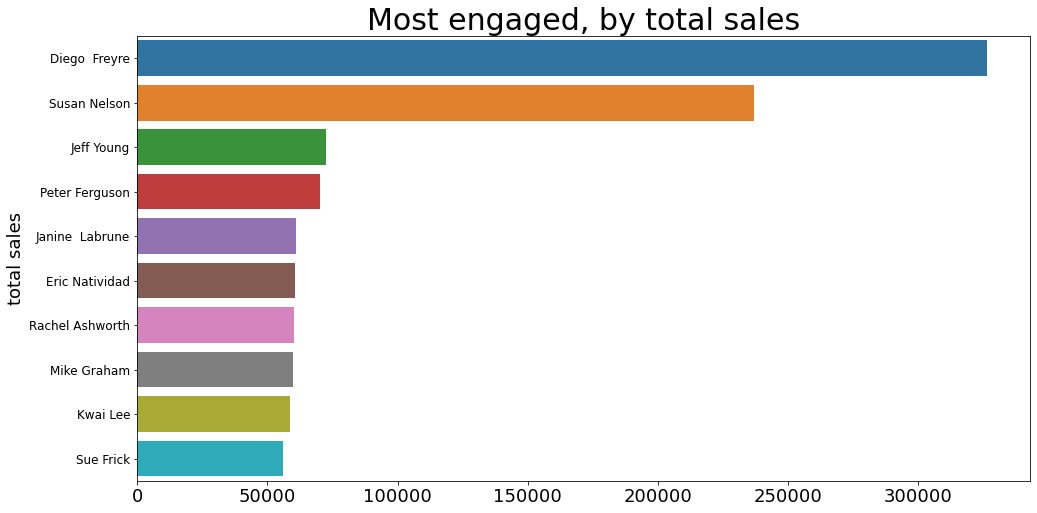

In [27]:
#df_1 = df_1.reset_index()

plt.figure(figsize=(16, 18))

plt.subplot(2, 1, 1)
sns.barplot(data=df_1, x='total', y='cust_name')
plt.xticks(fontsize=18)
plt.yticks(fontsize=12)
plt.ylabel("total sales", fontsize=18)
plt.xlabel("")
plt.title("Most engaged, by total sales", fontsize=30)

plt.show()

### Least engaged

In [28]:
query_2 = """

WITH VIP AS (SELECT o.customerNumber, ROUND(SUM(od.quantityOrdered * (od.priceEach - p.buyPrice)), 2) AS total
  FROM orders AS o
 INNER JOIN orderdetails AS od ON od.orderNumber = o.orderNumber
 INNER JOIN products AS p ON p.productCode = od.productCode
 GROUP BY o.customerNumber 
 ORDER BY total ASC
 LIMIT 10)

SELECT c.contactFirstName || " " || c.contactLastName AS cust_name, v.customerNumber, v.total, c.phone, c.country
  FROM customers AS c, VIP AS v
WHERE c.customerNumber = v.customerNumber
"""

conn = sqlite3.connect("stores.db")
df_2 = pd.read_sql_query(query_2, conn).set_index("customerNumber", drop=True) 


df_2

,cust_name,total,phone,country
customerNumber,,,,
219,Mary Young,2610.87,3105552373,USA
198,Leslie Taylor,6586.02,6175558428,USA
473,Franco Ricotti,9532.93,+39 022515555,Italy
103,Carine Schmitt,10063.80,40.32.2555,France
489,Thomas Smith,10868.04,(171) 555-7555,UK
381,Pascale Cartrain,11693.99,(071) 23 67 2555,Belgium
415,Michael Donnermeyer,13033.35,+49 89 61 08 9555,Germany
456,Yu Choi,13066.02,2125551957,USA
173,Jerry Tseng,13734.70,6175555555,USA


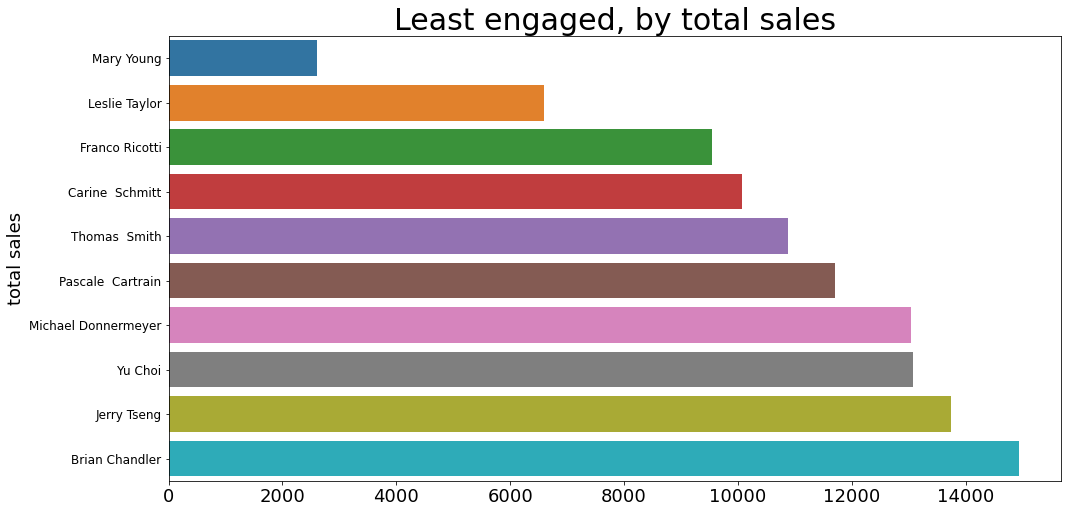

In [30]:
df_2 = df_2.reset_index()

plt.figure(figsize=(16, 18))

plt.subplot(2, 1, 1)
sns.barplot(data=df_2, x='total', y='cust_name')
plt.xticks(fontsize=18)
plt.yticks(fontsize=12)
plt.ylabel("total sales", fontsize=18)
plt.xlabel("")
plt.title("Least engaged, by total sales", fontsize=30)

plt.show()

# How much can we spend on acquiring new customers?

I firstly look at the rate of new customers the company acquires, by month. The idea is to identify any problems that the company might be having with attracting new customers - which would imply that it would be worthwhile investing money in this area.

Next, I workout how much money the company can spend acquiring new customers - this is done by calculating the LTV, which is represented by the average amount of money a customer spends.

In [60]:
%%sql

WITH 

payment_with_year_month_table AS (
SELECT *, 
       CAST(SUBSTR(paymentDate, 1,4) AS INTEGER)*100 + CAST(SUBSTR(paymentDate, 6,7) AS INTEGER) AS year_month
  FROM payments AS p
),

customers_by_month_table AS (
SELECT p1.year_month, COUNT(*) AS number_of_customers, SUM(p1.amount) AS total
  FROM payment_with_year_month_table AS p1
 GROUP BY p1.year_month
),

new_customers_by_month_table AS (
SELECT p1.year_month, 
       COUNT(*) AS number_of_new_customers,
       SUM(p1.amount) AS new_customer_total,
       (SELECT number_of_customers
          FROM customers_by_month_table AS c
        WHERE c.year_month = p1.year_month) AS number_of_customers,
       (SELECT total
          FROM customers_by_month_table AS c
         WHERE c.year_month = p1.year_month) AS total
  FROM payment_with_year_month_table AS p1
 WHERE p1.customerNumber NOT IN (SELECT customerNumber
                                   FROM payment_with_year_month_table AS p2
                                  WHERE p2.year_month < p1.year_month)
 GROUP BY p1.year_month
)

SELECT year_month, 
       ROUND(number_of_new_customers*100/number_of_customers,1) AS number_of_new_customers_props,
       ROUND(new_customer_total*100/total,1) AS new_customers_total_props
  FROM new_customers_by_month_table;


 * sqlite:///stores.db
Done.


year_month,number_of_new_customers_props,new_customers_total_props
200301,100.0,100.0
200302,100.0,100.0
200303,100.0,100.0
200304,100.0,100.0
200305,100.0,100.0
200306,100.0,100.0
200307,75.0,68.3
200308,66.0,54.2
200309,80.0,95.9
200310,69.0,69.3


### Customer lifetime value

In [9]:
%%sql

WITH 

money_in_by_customer_table AS (
SELECT o.customerNumber, SUM(quantityOrdered * (priceEach - buyPrice)) AS revenue
  FROM products p
  JOIN orderdetails od
    ON p.productCode = od.productCode
  JOIN orders o
    ON o.orderNumber = od.orderNumber
 GROUP BY o.customerNumber
)

SELECT AVG(mc.revenue) AS ltv
  FROM money_in_by_customer_table mc;

 * sqlite:///stores.db
Done.


ltv
39039.59438775511
